In [1]:
import numpy as np
from scipy.sparse import dia_array
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize

# Numerical solution of the heat equation using Python
The heat equation is 
$$u^{\prime} = \alpha \cdot \Delta u$$
where $u$ is an unknown function, $\alpha$ is the diffusivity constant and $\Delta$ is the Laplacian operator.

## Parameters
- `h`: $\Delta xy$, the step used for the two spatial domains
- `n`: the number of points in each spatial dimension - `n` by `n` grid
- `th`: $\Delta t$, the time step
- `t`: the number of time steps to evaluate
- `a`: $\alpha$, the diffusivity constant

`g` or $\gamma$ is $\frac{\alpha \cdot \Delta t}{\Delta xy^2}$, the coefficient for the discrete Laplacian operator.

If $\Delta t$ is greater than $\frac{\Delta xy^2}{4\alpha}$, the system will violently oscillate.

<img src="oscillating.gif" width="300"></img>

In [2]:
h = 1
n = 500
th = 0.125
t = 1000
a = 2

g = (a * th) / h**2

## Initial Conditions
The initial value must be a 1-dimensional array. In this case, the top of the simulation area is heated.

In [3]:
initial = np.array([[0 for i in range(n)] for i in range(n)])
initial[n//3:2*n//3, n//3:2*n//3] = 50

## Discrete Laplacian Operator
The heat equation can be numerically solved by constructing a tridiagonal matrix that represents the discrete Laplace operator:

$$\frac{\alpha \cdot \Delta t(u(x-h, y) + u(x+h, y) + u(x, y-h) + u(x, y+h) -4u(x, y))}{h^2}$$

monstrous tridiagonal matrix:
$$
\begin{pmatrix}
-2 &      1 &        &        &        &      1 &        &        &        &        &        \\
 1 &     -3 &  1     &        &        &        &      1 &        &        &        &        \\
   & \ddots & \ddots & \ddots &        &        &        &      1 &        &        &        \\
   &        &  1     &     -3 &      1 &        &        &        &      1 &        &        \\
   &        &        &      1 &     -2 &        &        &        &        &      1 &        \\
 1 &        &        &        &        &     -3 &      1 &        &        &        & \ddots \\
   &      1 &        &        &        &      1 &     -4 &      1 &        &        &        \\
   &        &      1 &        &        &        & \ddots & \ddots & \ddots &        &        \\
   &        &        &      1 &        &        &        &      1 &     -4 &      1 &        \\
   &        &        &        &      1 &        &        &        &      1 &     -3 &        \\
   &        &        &        &        &      1 &        &        &        &        & \ddots \\
   &        &        &        &        &        & \ddots &        &        &        &        \\
\end{pmatrix}
$$

This is then multiplied by $\gamma$. Since this gives the derivative of position according to the heat equation, the $n^2$ by $n^2$ identity matrix must be added element-wise to this so that it will give the new position when applied to a state.

In [4]:
data = np.array([
    [g for i in range(n**2)],
    np.tile([0] + [g for i in range(n-1)], n),
    np.append(np.append([-2] + [-3 for i in range(n-2)] + [-2],
                np.tile([-3] + [-4 for i in range(n-2)] + [-3], n-2)),
                        [-2] + [-3 for i in range(n-2)] + [-2]) * g + 1,
    np.tile([g for i in range(n-1)] + [0], n),
    [g for i in range(n**2)]
])

offsets = np.array([n, 1, 0, -1, -n])

A = dia_array((data, offsets), shape=(n**2, n**2)).tocsr()

## Solution
The discrete Laplacian is repeatedly applied to the previous frame, then any boundary conditions are applied (in this case, the top is a constant temperature).

In [5]:
Z = np.zeros((t, n**2), dtype=np.float32)
Z[0] = initial.flatten()

for i in range(1, t):
    Z[i] = A.dot(Z[i-1])
    Z[i][:n] = 50 # boundary condition

Z = Z.reshape((t, n, n))


Error: Canceled future for execute_request message before replies were done

## Plot
Matplotlib is used to generate an animation of the solution. The data has to be normalized manually, since otherwise Matplotlib would change the normalization range for each frame.

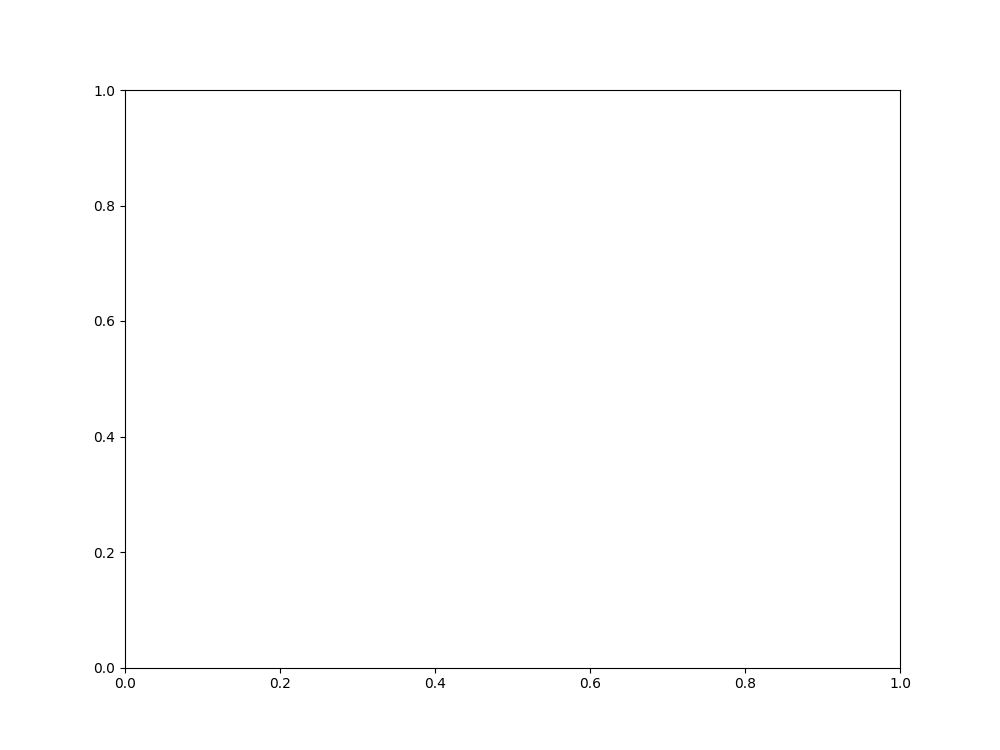

In [ ]:
%matplotlib widget

fig, ax = plt.subplots()

fig.set_dpi(96)
fig.set_figheight(7.5)
fig.set_figwidth(10)

norm = Normalize(np.min(initial), np.max(initial))

def animate(frame):
    ax.cla()
    ax.set_title(frame*4)
    ax.imshow(Z[frame*4], cmap='turbo', norm=norm)

anim = FuncAnimation(fig, animate, interval=33, frames=(t-1) // 4, repeat=False)

plt.show()
anim.save('heat.gif', savefig_kwargs={'facecolor': 'white'})
